In [1]:
import pytz
from datetime import datetime
from gym_mtsim import MtSimulator, Timeframe, MtEnv
import ta

In [2]:
sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

sim.download_data(
    symbols=['EURUSD', 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'],
    time_range=(
        datetime(2021, 6, 30, tzinfo=pytz.UTC),
        datetime(2023, 6, 30, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.D1
)

env = MtEnv(
    original_simulator=sim,
    trading_symbols=['EURUSD'],
    window_size=30,
    multiprocessing_processes=2
)

In [10]:
data = env.get_prices()['EURUSD']

In [11]:
data

array([[1.18961e+00, 1.18564e+00, 1.19083e+00, 1.18443e+00, 6.46740e+05],
       [1.18558e+00, 1.18492e+00, 1.18835e+00, 1.18366e+00, 6.11128e+05],
       [1.18492e+00, 1.18651e+00, 1.18736e+00, 1.18062e+00, 5.20890e+05],
       ...,
       [1.09596e+00, 1.09121e+00, 1.09617e+00, 1.08961e+00, 5.20492e+05],
       [1.09121e+00, 1.08629e+00, 1.09407e+00, 1.08594e+00, 5.14237e+05],
       [1.08629e+00, 1.09106e+00, 1.09312e+00, 1.08345e+00, 5.14608e+05]])

In [9]:
# just take o,h,l,c, v
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [5]:
from typing import List, Optional

def ppc(d: List[float]) -> List[Optional[float]]:
    """
    Calculate the percentage point change (PPC) for consecutive elements in a list.

    Args:
    d (List[float]): A list of numerical values.

    Returns:
    List[Optional[float]]: A list of PPC values where the first element is always None 
    (since there is no preceding element to compare with) and subsequent elements are 
    the PPC calculated between consecutive elements of the input list.

    The PPC is calculated as ((current_value - previous_value) / previous_value).
    If the previous value is 0, which would result in a division by zero, None is returned for that position.
    """

    # Copy the input list to avoid modifying the original data
    data = list(d.copy())
    res = list()
    for i in range(len(data)):
        if i == 0:
            # The first element has no previous element, so PPC is undefined
            res.append(None)
        else:
            # Check for division by zero scenario
            if data[i-1] == 0:
                res.append(None)
            else:
                # Calculate PPC
                res.append((data[i] - data[i-1]) / data[i-1])
    return res

In [16]:
data['ppc_close'] = ppc(data['Close'])
data['ma_10'] = ta.trend.sma_indicator(data['ppc_close'], 10)
data['ma_20'] = ta.trend.sma_indicator(data['ppc_close'], 20)
data['ma_50'] = ta.trend.sma_indicator(data['ppc_close'], 50)
bb = ta.volatility.BollingerBands(data['ppc_close'], 20, 2)
data['bb_bbm'] = bb.bollinger_mavg()
data['bb_bbh'] = bb.bollinger_hband()
data['bb_bbl'] = bb.bollinger_lband()
data['rsi'] = ta.momentum.rsi(data['Close'], 14)
#data['macd'], data['macd_signal'], data['macd_hist'] = ta.trend.macd(data['Close'], 12, 26, 9)
data['cci'] = ta.trend.cci(data['High'], data['Low'], data['Close'], 20)
data['adx'] = ta.trend.adx(data['High'], data['Low'], data['Close'], 14)

data

C:\Users\stefa\AppData\Local\Temp\ipykernel_12224\515222664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ppc_close'] = ppc(data['Close'])
C:\Users\stefa\AppData\Local\Temp\ipykernel_12224\515222664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ma_10'] = ta.trend.sma_indicator(data['ppc_close'], 10)
C:\Users\stefa\AppData\Local\Temp\ipykernel_12224\515222664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,Open,High,Low,Close,Volume,ppc_close,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,rsi,cci,adx,future_ppc
0,1.18961,1.19083,1.18443,1.18564,646740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001592
1,1.18558,1.18835,1.18366,1.18492,611128.0,-0.000607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001095
2,1.18492,1.18736,1.18062,1.18651,520890.0,0.001342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002294
3,1.18612,1.18799,1.18506,1.18609,422936.0,-0.000354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001975
4,1.18609,1.18943,1.18062,1.18229,652057.0,-0.003204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1.09027,1.09195,1.08865,1.09051,768333.0,0.001019,0.001399,0.000930,-0.000022,0.000930,0.009616,-0.007756,55.596072,65.462242,24.700945,NaN
519,1.09051,1.09761,1.09012,1.09596,661619.0,0.004998,0.001550,0.001053,-0.000013,0.001053,0.009895,-0.007789,60.286988,85.498285,24.059099,NaN
520,1.09596,1.09617,1.08961,1.09121,520492.0,-0.004334,0.000803,0.001048,-0.000067,0.001048,0.009903,-0.007807,54.848447,62.662865,23.362286,NaN
521,1.09121,1.09407,1.08594,1.08629,514237.0,-0.004509,-0.000736,0.000481,-0.000181,0.000481,0.009234,-0.008272,49.833814,32.502107,22.010153,NaN


In [7]:
import matplotlib.pyplot as plt
def plot(ppc, indicator, title):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ppc, label='ppc')
    ax.plot(indicator, label=title)
    ax.legend()
    plt.show()

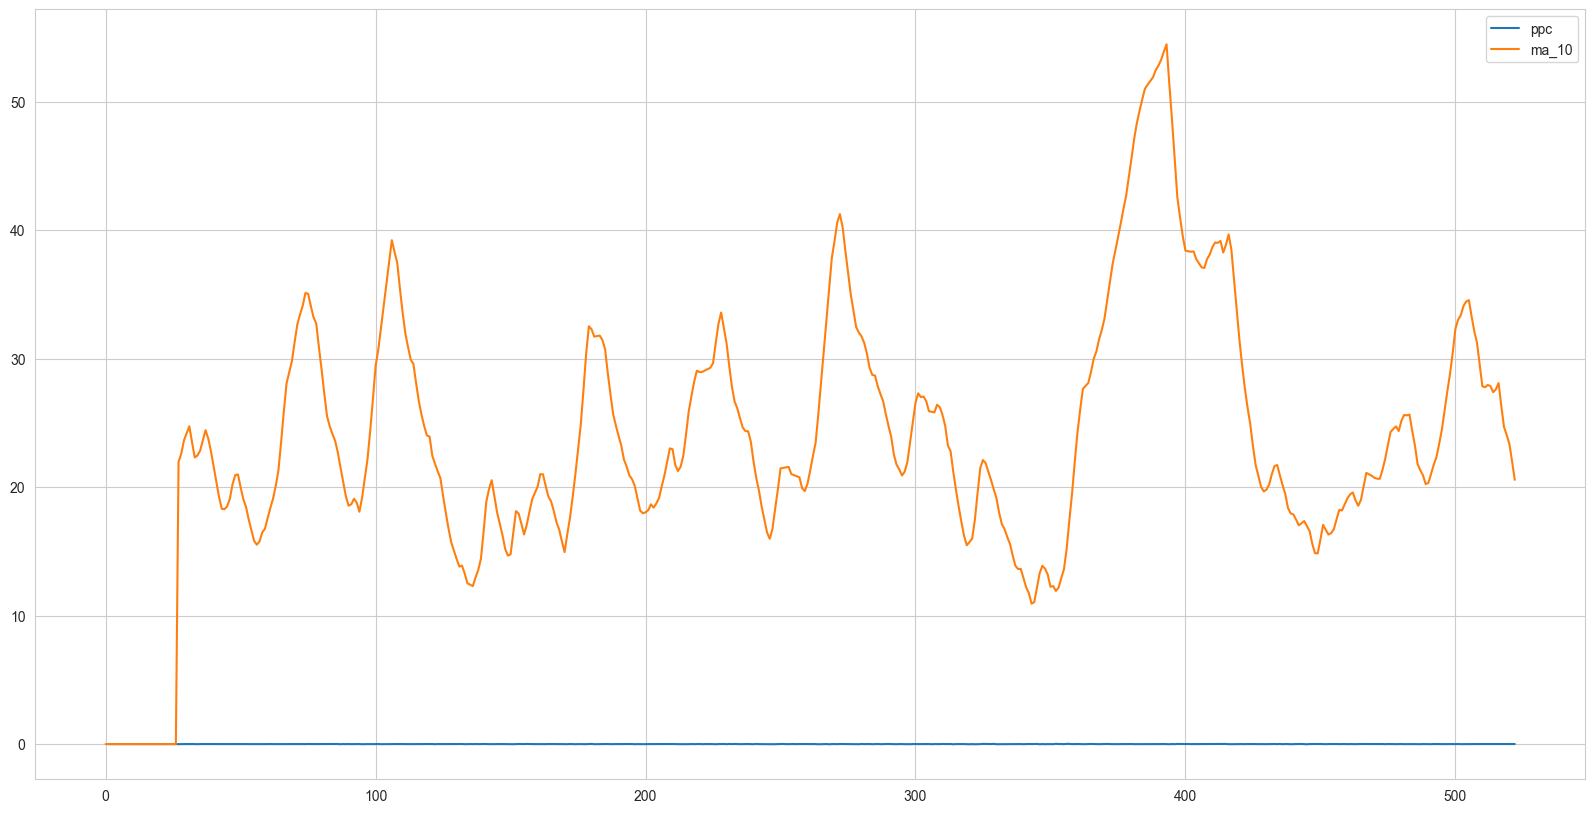

In [8]:
plot(data['ppc_close'], data['adx'], 'ma_10')

In [9]:
def future_avg_ppc(d: List[float], x: int = 5) -> List[Optional[float]]:
    """
    Calculate the average percentage point change (PPC) compared to the next X elements in a list.

    Args:
    d (List[float]): A list of numerical values.
    x (int): The number of future days to calculate the average PPC over.

    Returns:
    List[Optional[float]]: A list of average PPC values where each element is the average PPC calculated 
    between the current element and the next X elements in the list. Elements at the end of the list 
    that do not have X future elements will have a value of None.

    The average PPC is calculated as the average of ((next_value - current_value) / current_value) 
    for the next X elements. If the current value or any of the next X values are 0, 
    which would result in a division by zero, None is returned for that position.
    """

    data = list(d.copy())
    res = []

    for i in range(len(data)):
        if i + x > len(data) - 1:
            # Not enough future elements to calculate average PPC
            res.append(None)
        else:
            avg_ppc = 0
            valid_ppc_count = 0
            for j in range(1, x + 1):
                if data[i] == 0 or data[i + j] == 0:
                    # Skip calculation if division by zero would occur
                    continue
                avg_ppc += (data[i + j] - data[i]) / data[i]
                valid_ppc_count += 1

            if valid_ppc_count > 0:
                res.append(avg_ppc / valid_ppc_count)
            else:
                res.append(None)

    return res


In [10]:
data['future_ppc'] = future_avg_ppc(data['Close'])

C:\Users\stefa\AppData\Local\Temp\ipykernel_12224\2974242359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['future_ppc'] = future_avg_ppc(data['Close'])


In [11]:
data

,Open,High,Low,Close,Volume,ppc_close,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,rsi,cci,adx,future_ppc
0,1.18961,1.19083,1.18443,1.18564,646740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001592
1,1.18558,1.18835,1.18366,1.18492,611128.0,-0.000607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001095
2,1.18492,1.18736,1.18062,1.18651,520890.0,0.001342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002294
3,1.18612,1.18799,1.18506,1.18609,422936.0,-0.000354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.001975
4,1.18609,1.18943,1.18062,1.18229,652057.0,-0.003204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1.09027,1.09195,1.08865,1.09051,768333.0,0.001019,0.001399,0.000930,-0.000022,0.000930,0.009616,-0.007756,55.596072,65.462242,24.700945,NaN
519,1.09051,1.09761,1.09012,1.09596,661619.0,0.004998,0.001550,0.001053,-0.000013,0.001053,0.009895,-0.007789,60.286988,85.498285,24.059099,NaN
520,1.09596,1.09617,1.08961,1.09121,520492.0,-0.004334,0.000803,0.001048,-0.000067,0.001048,0.009903,-0.007807,54.848447,62.662865,23.362286,NaN
521,1.09121,1.09407,1.08594,1.08629,514237.0,-0.004509,-0.000736,0.000481,-0.000181,0.000481,0.009234,-0.008272,49.833814,32.502107,22.010153,NaN


In [17]:
# make a copy of the original data but without ohclv
data_p = data[['ppc_close', 'ma_10', 'ma_20', 'ma_50','bb_bbm', 'bb_bbh', 'bb_bbl', 'rsi', 'cci', 'adx', 'future_ppc']].copy()

In [18]:
data_p.dropna(inplace=True)
data_p

,ppc_close,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,rsi,cci,adx,future_ppc
50,-0.001951,0.000384,0.000332,-6.582221e-05,0.000332,0.005710,-0.005046,52.051589,56.969936,19.985050,-0.000169
51,0.000736,0.000622,0.000407,-3.895020e-05,0.000407,0.005763,-0.004949,53.390288,51.556437,19.057727,-0.001937
52,-0.000846,0.000169,0.000080,-8.270221e-05,0.000080,0.004876,-0.004716,51.606756,48.546333,18.447926,-0.002610
53,-0.000322,0.000123,0.000141,-8.205567e-05,0.000141,0.004884,-0.004601,50.910777,13.593652,17.458658,-0.003737
54,-0.000686,-0.000052,0.000398,-3.169654e-05,0.000398,0.004303,-0.003506,49.381998,31.767166,16.617915,-0.004381
...,...,...,...,...,...,...,...,...,...,...,...
513,-0.002029,0.001940,0.000511,1.272470e-04,0.000511,0.008731,-0.007709,60.928643,187.685846,27.855559,0.000952
514,-0.000348,0.002097,0.000690,2.283379e-05,0.000690,0.008669,-0.007289,60.434363,147.183280,27.383585,0.002079
515,0.006256,0.002667,0.001100,-9.052227e-07,0.001100,0.009334,-0.007135,65.804034,152.593813,27.607984,-0.005485
516,-0.002776,0.001607,0.001072,-1.567019e-04,0.001072,0.009354,-0.007209,61.772342,134.801021,28.099845,-0.004396


In [19]:
# convert to dataframe
import pandas as pd
data_p = pd.DataFrame(data_p, columns=['ppc_close', 'ma_10', 'ma_20', 'ma_50', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'rsi', 'cci', 'adx', 'future_ppc'])

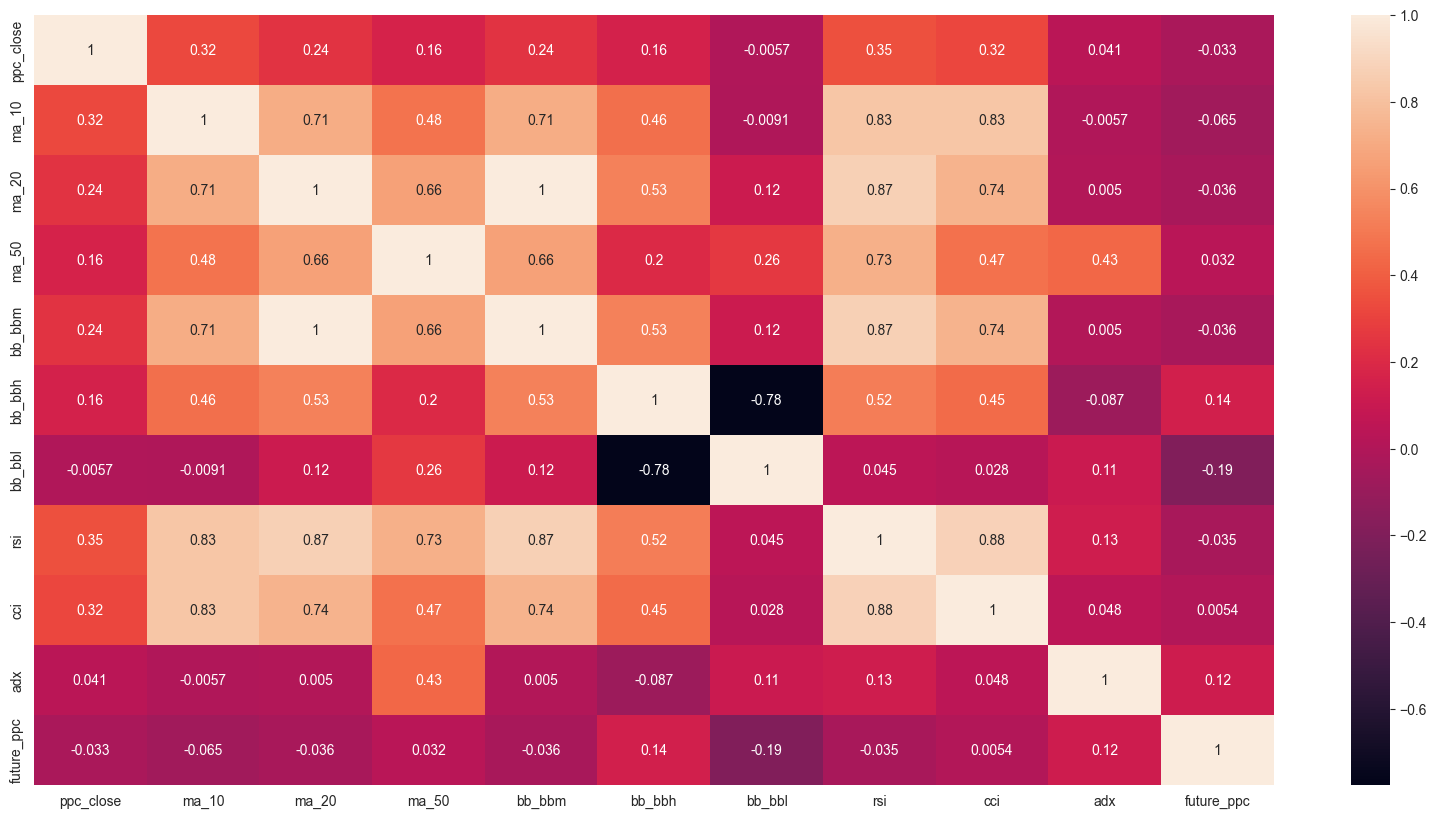

In [20]:
# make a beautiful correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
corr = data_p.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()


[0.06720119 0.08898713 0.0692989  0.12279469 0.07353818 0.10164618
 0.12101609 0.09064798 0.09121529 0.17365437]


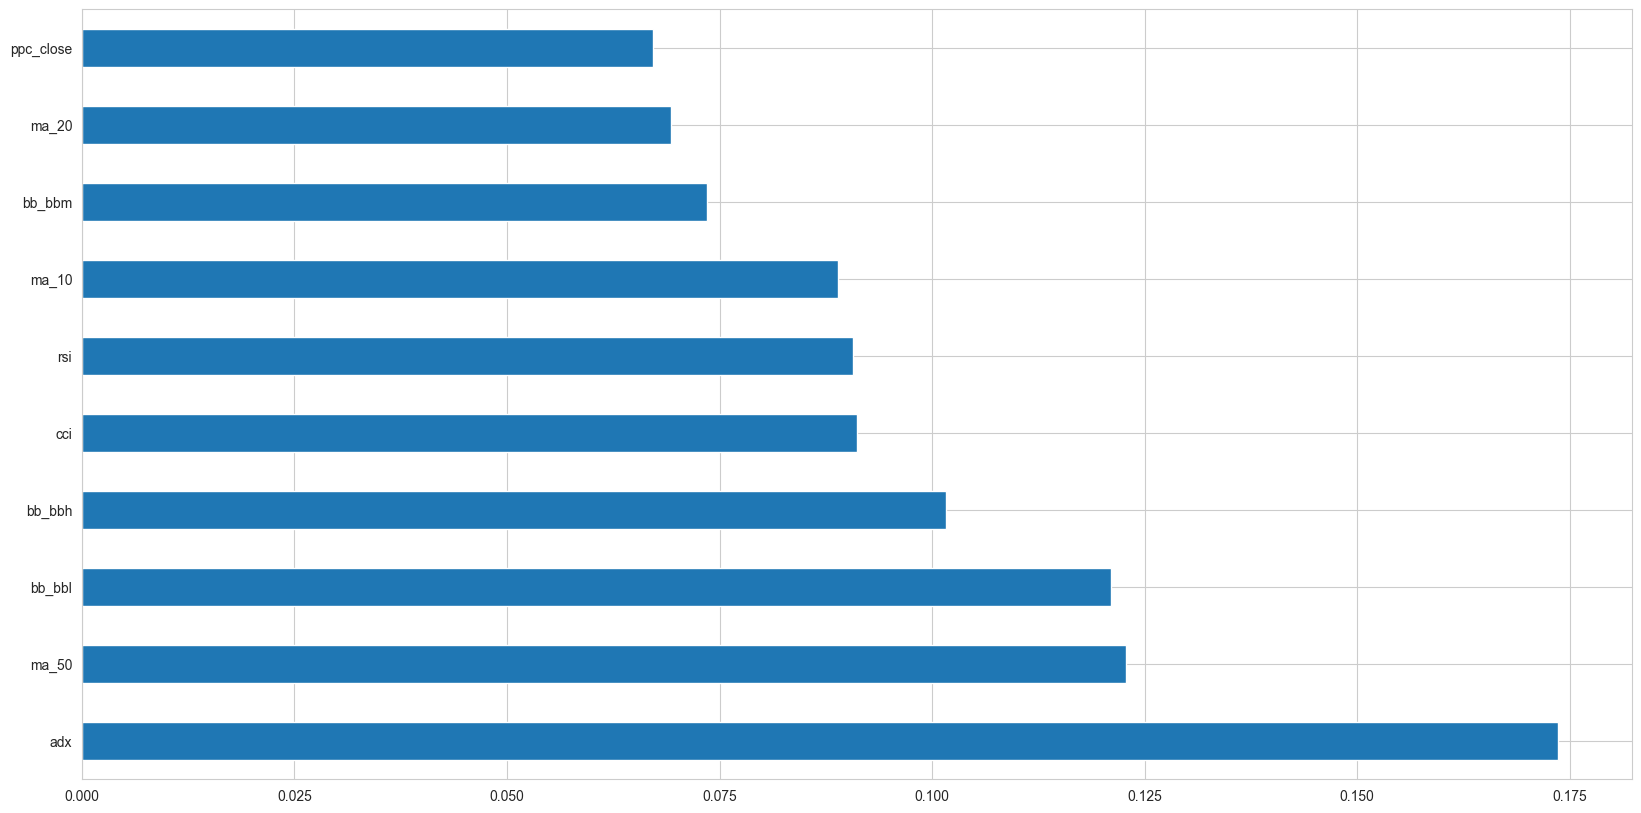

In [23]:
# test whick one are the most important features
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
X = data_p.drop('future_ppc', axis=1)
y = data_p['future_ppc']
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
fig, ax = plt.subplots(figsize=(20, 10))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()